# INTRODUCTION

# EXPLORATORY DATA ANALYSIS

## Business understanding of the problem

## Loading & First exploration

### Preliminary loading 

In [8]:
#Loading the necessary packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.model_selection import train_test_split

In [9]:
#Loading the datasets
df_airport = pd.read_csv("Raw_data/training_set_airport_data.csv")
df_geographic = pd.read_csv("Prepared_data/new_geographic_data.csv", sep = ";")
df_weather = pd.read_csv("Raw_data/Weather_data/weather_data_train_set.csv")
df_aircraft = pd.read_csv("Prepared_data/ACchar.csv", sep = ";")

### EDA of the training set airport data

In [10]:
df_airport.head()

,Flight Datetime,Aircraft Model,AOBT,ATOT,Stand,Runway
0,1/1/2015 6:00,B737-800 WINGLETS,1/1/2015 5:56,1/1/2015 6:05,STAND_62,RUNWAY_4
1,1/1/2015 6:10,A320-100/200,1/1/2015 6:08,1/1/2015 6:18,STAND_153,RUNWAY_4
2,1/1/2015 6:15,A320-100/200,1/1/2015 6:08,1/1/2015 6:19,STAND_44,RUNWAY_2
3,1/1/2015 6:20,A320-100/200,1/1/2015 6:24,1/1/2015 6:36,STAND_7,RUNWAY_3
4,1/1/2015 6:20,A319,1/1/2015 6:14,1/1/2015 6:27,STAND_17,RUNWAY_2


In [11]:
#Rename the columns
df_airport.rename(columns={'Flight Datetime':'flight_dt',
                          'Aircraft Model':'aircraft_model'}, 
                 inplace=True)

In [12]:
df_airport.describe()

,flight_dt,aircraft_model,AOBT,ATOT,Stand,Runway
count,543813,543813,543813,543813,543813,543813
unique,244764,143,461674,538720,166,4
top,5/2/2015 6:10,A319,2/4/2015 15:58,7/25/2016 6:10,STAND_61,RUNWAY_2
freq,9,178048,5,3,3453,136375


In [13]:
#Convert date string into date format
df_airport['flight_dt'] =  pd.to_datetime(df_airport['flight_dt'], format='%m/%d/%Y %H:%M')
df_airport['AOBT'] =  pd.to_datetime(df_airport['AOBT'], format='%m/%d/%Y %H:%M')
df_airport['ATOT'] =  pd.to_datetime(df_airport['ATOT'], format='%m/%d/%Y %H:%M')
df_airport.head()

,flight_dt,aircraft_model,AOBT,ATOT,Stand,Runway
0,2015-01-01 06:00:00,B737-800 WINGLETS,2015-01-01 05:56:00,2015-01-01 06:05:00,STAND_62,RUNWAY_4
1,2015-01-01 06:10:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:18:00,STAND_153,RUNWAY_4
2,2015-01-01 06:15:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:19:00,STAND_44,RUNWAY_2
3,2015-01-01 06:20:00,A320-100/200,2015-01-01 06:24:00,2015-01-01 06:36:00,STAND_7,RUNWAY_3
4,2015-01-01 06:20:00,A319,2015-01-01 06:14:00,2015-01-01 06:27:00,STAND_17,RUNWAY_2


In [14]:
# Create a function that computes the TaxiTime in minutes
def DatetimeToTaxitime(datetime1, datetime2):
    difference = datetime2 - datetime1
    taxitime = difference.value / 6e10
    return taxitime

# Compute the taxitime in the airport dataframe 
df_airport['taxitime'] = df_airport.apply(lambda x: DatetimeToTaxitime(x.AOBT, x.ATOT), axis =1)

In [15]:
len(df_airport)

543813

In [16]:
df_airport.describe()

,taxitime
count,543813.000000
mean,18.754785
std,8.172083
min,-218.000000
25%,14.000000
50%,18.000000
75%,22.000000
max,656.000000


In [17]:
#NA search: No NA to clean
df_airport.isnull().sum()

flight_dt         0
aircraft_model    0
AOBT              0
ATOT              0
Stand             0
Runway            0
taxitime          0
dtype: int64

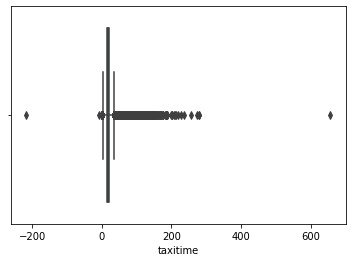

In [18]:
#Outliers search - there seems to some outliers 
# For some outiliers the ATOT is before the AOBT: there is a mistake so we should delete them
# For the others, we will see a strategy to handle the outliers in the data preparation section
ax = sns.boxplot(df_airport["taxitime"])

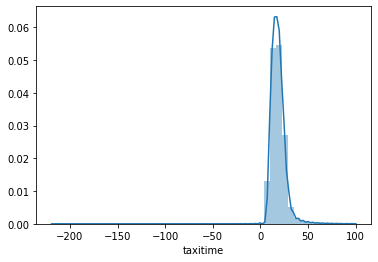

In [19]:
#We observe a quasi normal distribution
sns.distplot(df_airport[df_airport["taxitime"] <100].taxitime)

### EDA of the geographic dataset

In [20]:
df_geographic.head()

,runway_stand,Lat_runway,Lng_runway,Lat_stand,Lng_stand
0,RUNWAY_1STAND_1,54.755307,-0.02304,54.764575,0.000356
1,RUNWAY_1STAND_10,54.755307,-0.02304,54.764382,-0.001061
2,RUNWAY_1STAND_100,54.755307,-0.02304,54.766471,0.018516
3,RUNWAY_1STAND_101,54.755307,-0.02304,54.770003,0.020513
4,RUNWAY_1STAND_102,54.755307,-0.02304,54.769606,0.018924


In [21]:
# Create the functions that compute distance between runways & stands in kilometers
def degreesToRadians(degrees):
    return degrees * np.pi / 180

def distanceInMBetweenCoordinates(lat1, lon1, lat2, lon2):
    earthRadiusKm = 6371;

    dLat = degreesToRadians(lat2-lat1)
    dLon = degreesToRadians(lon2-lon1)

    lat1 = degreesToRadians(lat1)
    lat2 = degreesToRadians(lat2)

    calculation = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLon/2) * np.sin(dLon/2) * np.cos(lat1) * np.cos(lat2) 
    distance = 2 * math.atan2(np.sqrt(calculation), np.sqrt(1-calculation)) 
    return earthRadiusKm * distance * 1000

In [22]:
# Compute the distance in the aircraft dataframe
df_geographic['distance'] = df_geographic.apply(lambda x: distanceInMBetweenCoordinates(x.Lat_runway, x.Lng_runway, x.Lat_stand, x.Lng_stand), axis =1)

In [23]:
df_geographic.describe()

,Lat_runway,Lng_runway,Lat_stand,Lng_stand,distance
count,664.000000,664.000000,664.000000,664.000000,664.000000
mean,54.758773,-0.004747,54.767037,0.009493,1730.470344
std,0.002643,0.019280,0.003191,0.009616,897.514890
min,54.755307,-0.024107,54.761081,-0.009674,158.869217
25%,54.756667,-0.023307,54.764575,0.003887,992.633820
50%,54.759147,-0.007360,54.766618,0.009772,1461.000769
75%,54.761253,0.011200,54.769606,0.018498,2578.251494
max,54.761493,0.019840,54.773947,0.026379,3321.122245


In [24]:
#NA search: No NA to clean
df_geographic.isnull().sum()

runway_stand    0
Lat_runway      0
Lng_runway      0
Lat_stand       0
Lng_stand       0
distance        0
dtype: int64

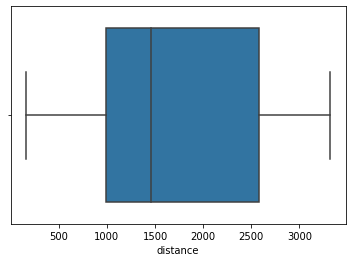

In [25]:
#Outliers search - there seems to be no outlier 
ax = sns.boxplot(df_geographic["distance"])

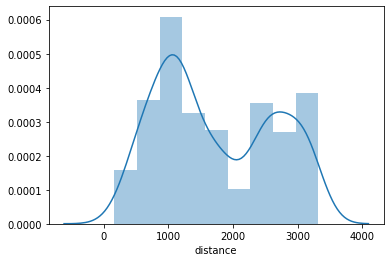

In [26]:
sns.distplot(df_geographic["distance"])

In [27]:
df_geographic = df_geographic[['runway_stand', 'distance']]

### EDA of the weather dataset

In [28]:
df_weather.head()

,time_hourly,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone
0,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
1,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
2,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
3,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
4,1/1/2015 6:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.65,39.29,42.8,0.93,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4


In [29]:
#Convert date string into date format
df_weather['time_hourly'] =  pd.to_datetime(df_weather['time_hourly'], format='%m/%d/%Y %H:%M')

In [30]:
#Rename the columns
df_weather.rename(columns={'time_hourly':'AOBT_hourly'}, 
                 inplace=True)

#Create hourly AOBT in airport data to join with weather data

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

# Compute the distance in the aircraft dataframe
df_airport['AOBT_hourly'] = df_airport.apply(lambda x: hour_rounder(x.AOBT), axis =1)

In [31]:
df_weather = df_weather.drop_duplicates()

In [32]:
df_weather.describe()

,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipAccumulation,ozone
count,29481.000000,29481.000000,33823.000000,33823.000000,33824.000000,33823.000000,29406.000000,33807.000000,30218.000000,32959.000000,32878.000000,33264.000000,33799.000000,33824.000000,33824.000000
mean,0.001401,0.037940,53.261394,51.952420,46.217615,0.788989,1015.562310,7.551346,10.969000,195.557845,0.519742,1.183862,6.097705,0.000012,314.011761
std,0.008215,0.146128,10.985435,12.514141,9.080322,0.154517,10.608472,4.600294,7.991617,93.995074,0.294911,1.790903,1.502209,0.000992,21.054959
min,0.000000,0.000000,17.670000,10.380000,12.190000,0.250000,971.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031000,0.000000,212.500000
25%,0.000000,0.000000,45.600000,42.150000,39.220000,0.680000,1009.600000,4.690000,5.660000,124.000000,0.190000,0.000000,6.216000,0.000000,310.400000
50%,0.000000,0.000000,52.620000,52.620000,46.410000,0.820000,1016.700000,6.930000,9.180000,220.000000,0.480000,0.000000,6.216000,0.000000,310.400000
75%,0.000000,0.000000,60.860000,60.860000,53.590000,0.930000,1022.600000,10.290000,14.050000,260.000000,0.750000,2.000000,6.216000,0.000000,310.400000
max,0.332800,1.000000,93.510000,96.700000,69.450000,1.000000,1045.700000,33.120000,51.310000,359.000000,1.000000,9.000000,10.000000,0.137400,480.000000


### EDA of the aircraft dataset

In [33]:
df_aircraft.head()

,aircraft_model,Manufacturer,Engines,Wingspan__ft,Length__ft,Tail_Height__ft,Wheelbase__ft,Wake_Category
0,100,Fokker,2,82.761111,92.246528,27.993056,31.941667,M
1,328,Fairchild Dornier,2,90.944444,72.560306,25.566667,35.875490,M
2,340,Cessna,2,38.108333,43.333333,12.583333,18.065564,L
3,407,Bell Helicopter,2,74.394553,72.560306,22.432559,35.875490,L
4,2000,Saab,2,74.394553,72.560306,22.432559,35.875490,L


In [34]:
len(df_aircraft)

142

## Data analysis

### Combining all datasets

In [35]:
#Let's combine our training set with the aircraft dataset (the key is the model)
df_train = pd.merge(df_airport, df_aircraft ,on='aircraft_model',how='left')

#Let's combine our training set with the geographic dataset (the key is the runway & the stand)
df_train['runway_stand'] = df_train['Runway'] + df_train['Stand']
df_train = pd.merge(df_train, df_geographic ,on='runway_stand',how='left')

#Let's combine our training set with the weather dataset (the key is the datetime)
df_train = pd.merge(df_train, df_weather ,on = 'AOBT_hourly', how='left')

In [36]:
len(df_train)

543813

### Correlation analysis

In [30]:
df_train.head()

,flight_dt,aircraft_model,AOBT,ATOT,Stand,Runway,taxitime,AOBT_hourly,Manufacturer,Engines,...,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone
0,2015-01-01 06:00:00,B737-800 WINGLETS,2015-01-01 05:56:00,2015-01-01 06:05:00,STAND_62,RUNWAY_4,9.0,2015-01-01 06:00:00,Boeing,2.0,...,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
1,2015-01-01 06:10:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:18:00,STAND_153,RUNWAY_4,10.0,2015-01-01 06:00:00,Airbus,2.0,...,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
2,2015-01-01 06:15:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:19:00,STAND_44,RUNWAY_2,11.0,2015-01-01 06:00:00,Airbus,2.0,...,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
3,2015-01-01 06:20:00,A320-100/200,2015-01-01 06:24:00,2015-01-01 06:36:00,STAND_7,RUNWAY_3,12.0,2015-01-01 06:00:00,Airbus,2.0,...,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4
4,2015-01-01 06:20:00,A319,2015-01-01 06:14:00,2015-01-01 06:27:00,STAND_17,RUNWAY_2,13.0,2015-01-01 06:00:00,Airbus,2.0,...,1031.6,10.29,11.39,210.0,0.75,0.0,5.859,None,0.0,310.4


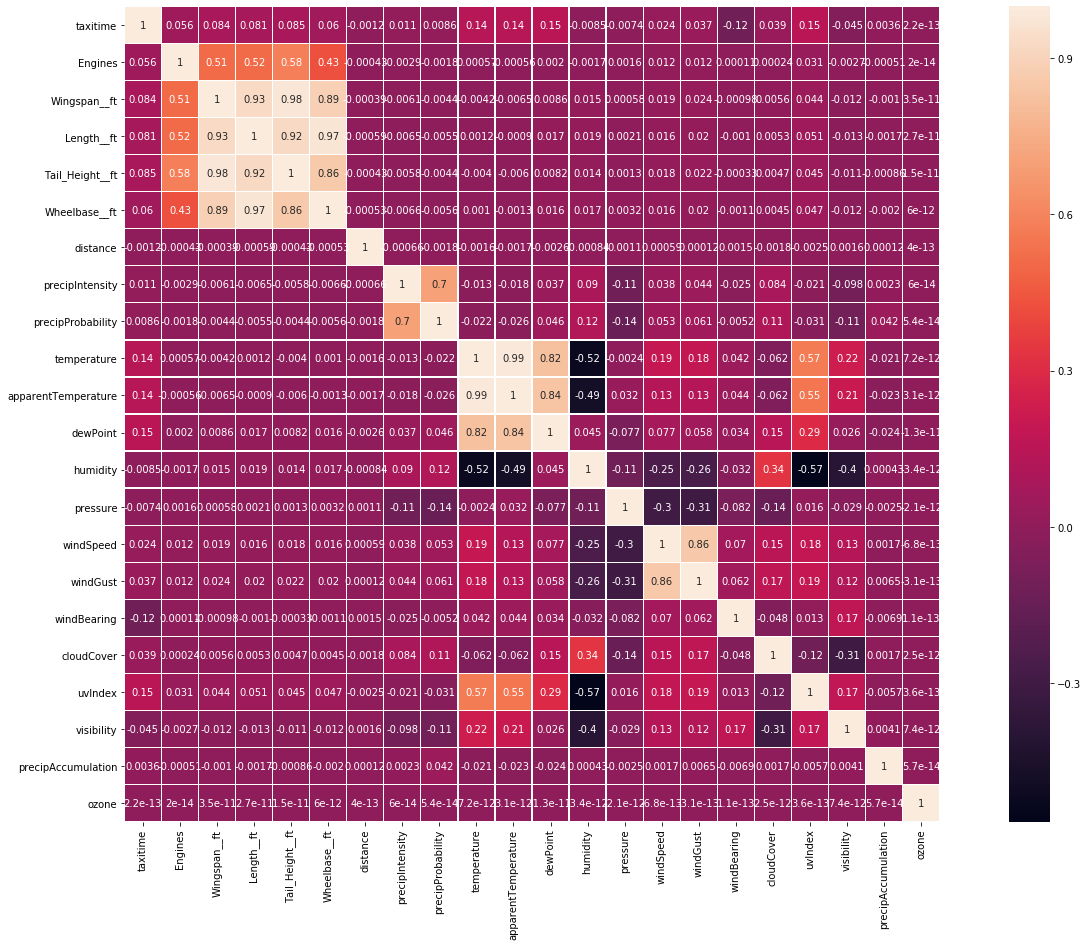

In [47]:
#Display the correlation matrix between the variables 
base_correlation = df_train.drop(['flight_dt', 'AOBT', 'ATOT', 'AOBT_hourly'], axis=1)
corrMatrix = base_correlation.corr()
plt.figure(figsize = (25,15))
sns.heatmap(corrMatrix, annot=True, square=True, linewidths=.3)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


<Figure size 1008x1008 with 0 Axes>

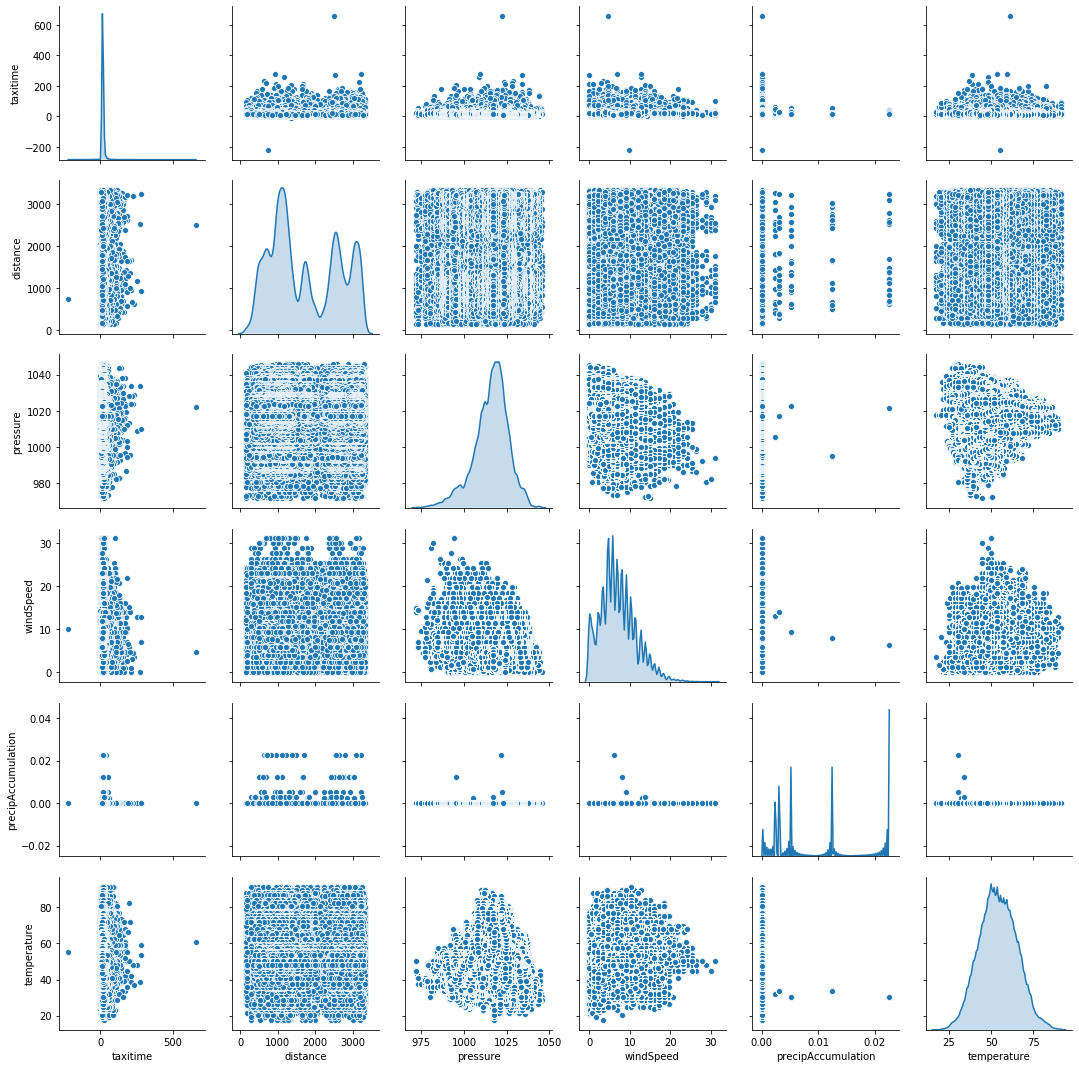

In [32]:
base_pairplot = df_train[['taxitime', 'distance', 'pressure', 'windSpeed', 'precipAccumulation', 'temperature']]
plt.figure(figsize=(14, 14))

sns.pairplot(base_pairplot, diag_kind='kde')

### Time series analysis

In [34]:
# Set date as index
df_ts = df_train.set_index('AOBT')
df_ts = df_ts.drop(['flight_dt', 'ATOT', 'AOBT_hourly'], axis=1)

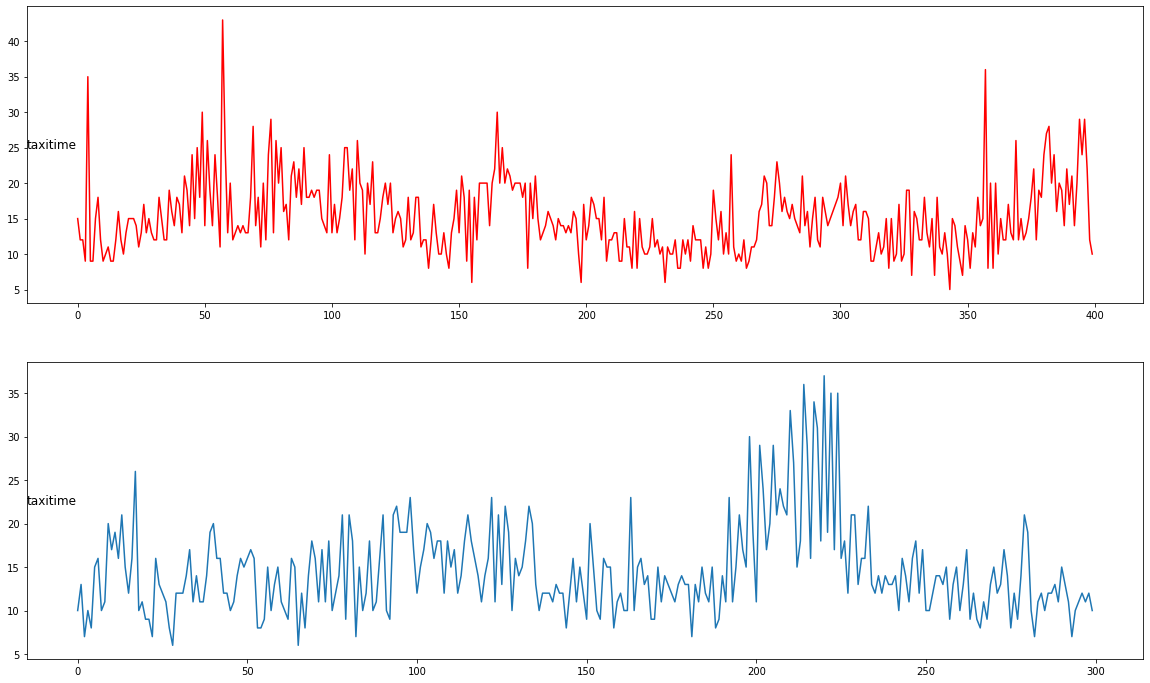

In [35]:
#The models ARIMA etc won't work on this data where no pattern can be found
plt.figure(figsize=(20,12)) #set the figure size

plt.subplot(2, 1, 1)
values_1 = df_ts[['taxitime']].values
plt.plot(values_1[300:700], color = 'red')    
plt.title('taxitime', y=0.5, loc='left')

plt.subplot(2, 1, 2)
values_2 = df_ts[['taxitime']].values
plt.plot(values_2[5000:5300])    
plt.title('taxitime', y=0.5, loc='left')

plt.show()

# DATA PREPARATION

## Data cleaning

### Missing values cleaning

In [120]:
df_train.isnull().sum()

flight_dt                  0
aircraft_model             0
AOBT                       0
ATOT                       0
Stand                      0
Runway                     0
taxitime                   0
AOBT_hourly                0
Manufacturer              38
Engines                   38
Wingspan__ft              38
Length__ft                38
Tail_Height__ft           38
Wheelbase__ft             38
Wake_Category             38
runway_stand               0
Lat_runway                 0
Lng_runway                 0
Lat_stand                  0
Lng_stand                  0
distance                   0
summary                91918
icon                   91918
precipIntensity        89356
precipProbability      89356
temperature             2423
apparentTemperature     2423
dewPoint                2395
humidity                2423
pressure               90838
windSpeed               2739
windGust               74419
windBearing            20471
cloudCover             21218
uvIndex       

In [121]:
#We can drop the missing values for all the column where they correspond to delete (because less than 1% of the huge dataset)
subset_delete = ['Manufacturer', 'Engines', 'Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 
                'Wheelbase__ft', 'Wake_Category', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
                'windSpeed', 'visibility', 'precipType', 'precipAccumulation', 'ozone']
df_train = df_train.dropna(subset = subset_delete)

In [122]:
#For the remaining NAs value (weather data), 
#we are going to use the method fillna assuming that the weather does not change as much from one hour to another
df_train = df_train.fillna(method='ffill')

### Deal with the outliers of taxitime

In [123]:
#From the EDA and the Outliers search for the variable to predict - there seems to be some outliers 
# For some outiliers the ATOT is before the AOBT: there is a mistake so we should delete them

#Delete the taxitime < 0 (we assume that there is a mistake)
df_train = df_train[df_train["taxitime"] > 0]



In [124]:
# For the others, we will use Z-score strategy to identify Data point that falls outside of 3 standard deviations 
z_score = np.abs(stats.zscore(df_train.taxitime))
threshold = 3
print(len(np.where(z_score > 3)[0]))

df_train = df_train[(z_score< 3)]

7171


In [125]:
len(df_train)

533526

## Features engineering

### Computing log(distance)

In [126]:
df_train['log_distance'] = np.log(df_train['distance'])

### Computing Q and N

In [127]:
## ATTEMPT USING PARALLELIZATION OF COMPUTATION
import time

#Checking if a date is in the interval [date1,date2]
def CheckDateInInterval(date,date1,date2):
    if date >= date1 and date2 >= date:
        return 1
    else:
        return 0

#Initializing N & Q list
Q_list = []
N_list = []

#Creating one list of all AOBTs and one list of all ATOTs
interval_list1 = list(df_train['AOBT'])
interval_list2 = list(df_train['ATOT'])

start_time = time.time()

#We take as a window the number of Stands in the airport (166)
# Here we assume at most, there is as much airplanes in taxitime at the same time than the number of stands 
window = len(df_train['Stand'].unique())

for row in range(len(df_train)):
    #Setting the AOBT and ATOT of a given row
    AOBT = interval_list1[row]
    ATOT = interval_list2[row]
    
    #Defining the min and max rows in the dataframe this iteration will have to consider
    min_row = max(0, row - window)
    max_row = min(row + window, len(df_train))
    
    short_list1 = interval_list1[min_row : max_row]
    short_list2 = interval_list2[min_row : max_row]
    
    #Creating a list of Booleans where there is 1 if for this iteration the row meets the condition for N
    N_boolean = map(lambda x, y : CheckDateInInterval(AOBT, x, y), short_list1, short_list2)
    #Computing the sum of the airplane satisfying the condition for N
    N_number = max(sum(list(N_boolean))-1, 0)
    N_list.append(N_number)

    #Creating a list of Booleans where there is 1 if for this iteration the row meets the condition for Q
    Q_boolean = map(lambda y : CheckDateInInterval(y, AOBT, ATOT), short_list2)
    #Computing the sum of the airplane satisfying the condition for Q
    Q_number = max(0, sum(list(Q_boolean))-1)
    Q_list.append(Q_number)
    
    if row % 50000 == 0:
        running_time = time.time() - start_time
        print("Row number: ", row, "/ Running time: " , running_time)

df_train['N'] = N_list        
df_train['Q'] = Q_list

Row number:  0 / Running time:  0.11523580551147461
Row number:  50000 / Running time:  21.456403970718384
Row number:  100000 / Running time:  37.81154179573059
Row number:  150000 / Running time:  54.50128102302551
Row number:  200000 / Running time:  72.82321095466614
Row number:  250000 / Running time:  88.44644093513489
Row number:  300000 / Running time:  103.96547079086304
Row number:  350000 / Running time:  118.18986678123474
Row number:  400000 / Running time:  135.18382477760315
Row number:  450000 / Running time:  150.63030195236206
Row number:  500000 / Running time:  165.8371868133545


In [128]:
len(df_train)

533526

In [129]:
df_train.describe()

,taxitime,Engines,Wingspan__ft,Length__ft,Tail_Height__ft,Wheelbase__ft,Lat_runway,Lng_runway,Lat_stand,Lng_stand,...,windGust,windBearing,cloudCover,uvIndex,visibility,precipAccumulation,ozone,log_distance,N,Q
count,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,...,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,533526.000000,5.335260e+05,533526.000000,533526.000000,533526.000000
mean,18.210550,2.036746,120.451541,129.087460,41.648108,46.027937,54.758773,-0.004758,54.767036,0.009495,...,10.976006,195.849096,0.494749,1.445092,5.747073,0.000002,3.104000e+02,7.295907,7.214188,7.059047
std,6.113591,0.270037,27.247422,27.949612,6.750549,13.427928,0.002641,0.019268,0.003184,0.009607,...,7.717675,95.725222,0.284818,1.952097,1.164289,0.000159,3.118888e-09,0.601176,3.107219,3.414980
min,1.000000,1.000000,23.250000,20.666667,6.895833,8.291118,54.755307,-0.024107,54.761081,-0.009674,...,0.000000,0.000000,0.000000,0.000000,0.031000,0.000000,3.104000e+02,5.068081,0.000000,0.000000
25%,14.000000,2.000000,111.880000,111.020000,39.630000,36.230000,54.757120,-0.024107,54.764575,0.003887,...,5.650000,120.000000,0.190000,0.000000,6.216000,0.000000,3.104000e+02,6.900441,5.000000,5.000000
50%,18.000000,2.000000,111.880000,123.270000,39.730000,41.470000,54.757120,-0.023040,54.766613,0.010050,...,9.180000,221.000000,0.440000,0.000000,6.216000,0.000000,3.104000e+02,7.288328,7.000000,7.000000
75%,22.000000,2.000000,117.416667,129.500000,41.416667,51.166667,54.761173,0.019840,54.769606,0.018498,...,14.857500,262.000000,0.750000,2.000000,6.216000,0.000000,3.104000e+02,7.854411,10.000000,9.000000
max,43.000000,4.000000,261.650000,247.240000,78.960000,107.870000,54.761493,0.019840,54.773947,0.026379,...,49.450000,359.000000,1.000000,9.000000,6.216000,0.022600,3.104000e+02,8.108058,19.000000,27.000000


### Converting Date data

In [130]:
pi = np.pi


def date_transfo(df):
#Transform Date into several column
    df['hour'] = df['AOBT'].dt.hour
    df['month'] = df['AOBT'].dt.month
    df['quarter'] = df['AOBT'].dt.quarter
    
    #Where average taxitime < 15 mins
    df_train['off-peak_hour'] = ((df_train['hour'] <4) + (df_train['hour'] >21 ))*1
    
    # Get circular hour
    df['hour_sin'] = np.sin(pi* df['hour'].astype(np.float64) /12)
    df['hour_cos'] = np.cos(pi* df['hour'].astype(np.float64) /12)
    df['month_sin'] = np.sin(pi* df['month'].astype(np.float64) /6)
    df['month_cos'] = np.cos(pi* df['month'].astype(np.float64) /6)
    df['quarter_sin'] = np.sin(pi* df['quarter'].astype(np.float64) /2)
    df['quarter_cos'] = np.cos(pi* df['quarter'].astype(np.float64) /2)

    return(df)

df_train = date_transfo(df_train)

/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [131]:
visualisation = df_train[['hour', 'month', 'quarter', 'taxitime']]
visualisation.groupby('hour').mean()

,month,quarter,taxitime
hour,,,
0,7.406015,2.774436,11.639098
1,6.100000,2.340000,11.260000
2,6.153846,2.352564,11.307692
3,6.876344,2.559140,10.946237
4,7.101061,2.722107,14.070515
5,6.851959,2.641376,17.020802
6,6.575096,2.527461,18.542352
7,6.539013,2.505837,19.678400
8,6.510001,2.499484,19.114958


### Converting categorical variables

In [132]:
df_train.columns

Index(['flight_dt', 'aircraft_model', 'AOBT', 'ATOT', 'Stand', 'Runway',
       'taxitime', 'AOBT_hourly', 'Manufacturer', 'Engines', 'Wingspan__ft',
       'Length__ft', 'Tail_Height__ft', 'Wheelbase__ft', 'Wake_Category',
       'runway_stand', 'Lat_runway', 'Lng_runway', 'Lat_stand', 'Lng_stand',
       'distance', 'summary', 'icon', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
       'uvIndex', 'visibility', 'precipType', 'precipAccumulation', 'ozone',
       'log_distance', 'N', 'Q', 'hour', 'month', 'quarter', 'off-peak_hour',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

In [133]:
df_train = df_train.join(pd.get_dummies(df_train['icon'], prefix='i'))

df_train = df_train.join(pd.get_dummies(df_train['precipType'], prefix='pt'))

#For the Wake Category, we are going to use Label Encoder as there is a linear combination between the wake and the taxitime
df_train.Wake_Category.replace({'L': 1, 'M': 2, 'H': 3}, inplace=True)

In [134]:
#Features per manufacturer
avg_manuf = df_train[['Manufacturer', 'taxitime']].groupby('Manufacturer').mean()

avg_manuf.rename(columns={'taxitime':'avg_manuf'}, 
                 inplace=True)

df_train = pd.merge(df_train, avg_manuf ,on='Manufacturer',how='left')


In [139]:
#Delete useless columns
df_train = df_train.drop(['flight_dt', 'ATOT', 'AOBT_hourly', 
                         'Lat_runway', 'Lng_runway', 'Lat_stand', 'Lng_stand'], axis = 1)

In [140]:
df_train.columns

Index(['aircraft_model', 'AOBT', 'Stand', 'Runway', 'taxitime', 'Manufacturer',
       'Engines', 'Wingspan__ft', 'Length__ft', 'Tail_Height__ft',
       'Wheelbase__ft', 'Wake_Category', 'runway_stand', 'distance', 'summary',
       'icon', 'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'precipType', 'precipAccumulation', 'ozone', 'log_distance', 'N', 'Q',
       'hour', 'month', 'quarter', 'off-peak_hour', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'i_clear-day',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 'pt_None',
       'pt_rain', 'pt_snow', 'avg_manuf'],
      dtype='object')

In [141]:
df_train.to_csv('clean_training_set_vf.csv.zip', index=False,
          compression='gzip')

# MODELLING

## Defining metrics

In [62]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(y_actual, y_predict):
    rmse = sqrt(mean_squared_error(y_actual, y_predict))
    return rmse

In [63]:
# Accuracy
def accuracy(y_actual, y_predict):
    lenght = len(y_actual)
    accuracy_1 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 1) *1) / lenght
    accuracy_2 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 2) *1) / lenght
    accuracy_3 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 3) *1) / lenght
    accuracy_5 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 5) *1) / lenght
    accuracy_10 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 10) *1) / lenght
    
    return accuracy_1, accuracy_2, accuracy_3, accuracy_5, accuracy_10

## Compute moving average

In [158]:
# Load final dataset
clean_data = pd.read_csv("clean_training_set_vf.csv")

In [161]:
clean_data['AOBT'] = pd.to_datetime(clean_data['AOBT'])
moving_avg = clean_data[['AOBT', 'taxitime']]
moving_avg = moving_avg.set_index('AOBT')

#Display each minute within 2015 & 2018
moving_avg = moving_avg.groupby(pd.Grouper(freq = "min")).mean()
moving_avg = moving_avg.reset_index()

#Compute the moving average of taxitime for each row, rolling 2 months before (ie 87840 minutes)
moving_avg['moving_avg'] = moving_avg['taxitime'].rolling(window = 87840, min_periods = 1).mean()

#Shift 1 because the rolling average takes into account the actual  row
moving_avg['moving_avg'] = moving_avg['moving_avg'].shift(1)

#Round the nearest integer
moving_avg['moving_avg'] = moving_avg['moving_avg'].round(0)

# For the first 2 months, replace the values by the global mean
moving_avg['moving_avg'][0:87840] = moving_avg['taxitime'].mean()

moving_avg = moving_avg.dropna()
moving_avg = moving_avg.reset_index()

#Combine the moving_avg table with our clean dataset
df_train = pd.merge(clean_data, moving_avg[['AOBT', 'moving_avg']] ,on = 'AOBT', how='left')

/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [166]:
df_train[['taxitime', 'moving_avg']].describe()

,taxitime,moving_avg
count,533526.000000,533526.000000
mean,18.210550,18.151134
std,6.113591,1.468332
min,1.000000,15.000000
25%,14.000000,17.000000
50%,18.000000,18.000000
75%,22.000000,19.000000
max,43.000000,21.000000


In [164]:
print(rmse(df_train['moving_avg'], df_train['taxitime']))
print(accuracy(df_train['moving_avg'], df_train['taxitime']))

6.030362468473043
(0.5633033816533777, 0.6315605987337074, 0.6976248580200403, 0.8192046873067105, 0.9862293496474399)


## Split into train and test sets

In [74]:
#Split the dataset into X & y (where y is the variable to predict)
df_y = df_train['taxitime']
df_X = df_train.drop(['taxitime'], axis=1)

In [75]:
# Split test & train randomly
X_train, X_test, y_train, y_test = train_test_split(
     df_X, df_y, test_size=0.2, random_state=42)

In [76]:
X_train.columns

Index(['Engines', 'Wingspan__ft', 'Length__ft', 'Tail_Height__ft',
       'Wheelbase__ft', 'Wake_Category', 'distance', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing',
       'cloudCover', 'uvIndex', 'visibility', 'precipAccumulation', 'ozone',
       'log_distance', 'N', 'Q', 'hour', 'month', 'quarter', 'off-peak_hour',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos', 'i_clear-day', 'i_clear-night', 'i_cloudy', 'i_fog',
       'i_partly-cloudy-day', 'i_partly-cloudy-night', 'i_rain', 'i_snow',
       'i_wind', 'pt_None', 'pt_rain', 'pt_snow', 'avg_manuf',
       'moving_average'],
      dtype='object')

## Features importance & selection

### Coefficients as Feature Importance

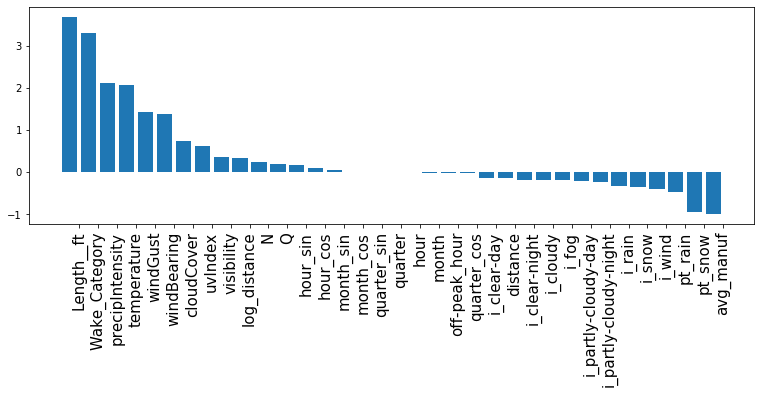

In [182]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

features = ['Length__ft', 'Wake_Category', 
       'precipIntensity','temperature',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'log_distance', 'N', 'Q', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'quarter_sin', 'quarter',
       'hour', 'month', 'off-peak_hour', 
        'quarter_cos', 'i_clear-day', 'distance',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 
       'pt_rain', 'pt_snow', 'avg_manuf']
train = X_train[features]
test = X_test[features]

# define the model
model_reg = LinearRegression()
# fit the model
model_reg.fit(train, y_train)
# get importance
ordering = np.argsort(model_reg.coef_)[::-1][:50]
importance = model_reg.coef_[ordering]

x = np.arange(len(features))
fig = plt.figure(figsize=(13,4))
plt.bar(x, importance)
plt.xticks(x + 0.5, features, rotation=90, fontsize=15);



### Random Forest Feature Importance

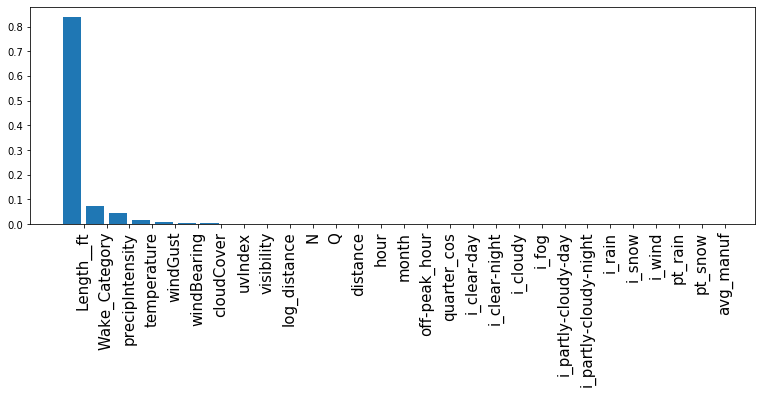

In [186]:
from sklearn.ensemble import RandomForestRegressor

features = ['Length__ft', 'Wake_Category', 
       'precipIntensity','temperature',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'log_distance', 'N', 'Q', 'distance',
       'hour', 'month', 'off-peak_hour', 
        'quarter_cos', 'i_clear-day',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 
       'pt_rain', 'pt_snow', 'avg_manuf']

train = X_train[features]
test = X_test[features] 

model_rf = RandomForestRegressor(
         n_estimators=10, max_depth=10)

model_rf.fit(train, y_train)

ordering = np.argsort(model_rf.feature_importances_)[::-1][:50]

importances = model_rf.feature_importances_[ordering]

x = np.arange(len(features))
fig = plt.figure(figsize=(13,4))
plt.bar(x, importances)
plt.xticks(x + 0.5, features, rotation=90, fontsize=15);

### XGBoost Feature Importance

In [192]:
# Find feature importance using XGboost algorithm
import xgboost as xgb

features = ['Length__ft', 'Wake_Category', 
       'precipIntensity','temperature',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'log_distance', 'N', 'Q', 'distance',
       'hour', 'month', 'off-peak_hour', 
        'quarter_cos', 'i_clear-day',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 
       'pt_rain', 'pt_snow', 'avg_manuf']

# Regressor choice with basic parameters
model_xgb = xgb.XGBRegressor( colsample_bytree=1, 
             importance_type='gain', learning_rate=0.1, max_depth=5, 
            min_child_weight=1, n_estimators=20, objective='reg:squarederror', 
            random_state=0, subsample=1, verbosity=0)

train = X_train[features]
test = X_test[features]

model_xgb.fit(train, y_train,
        eval_set=[(train, y_train), (test, y_test)],
        early_stopping_rounds=10,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

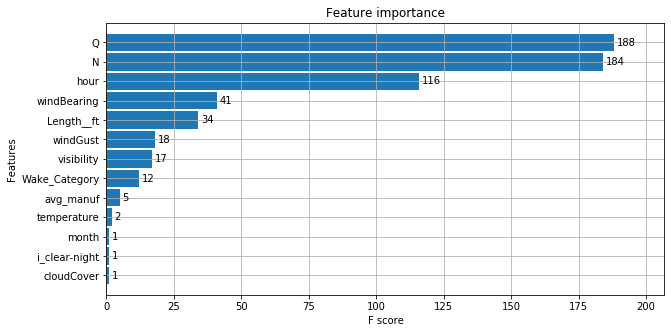

In [193]:
#Plot the features importance of the first 20 most importance features
fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(model_xgb, ax=ax, height=0.9, max_num_features=20)
plt.show()

In [190]:
predict_rf = model_rf.predict(test)
print(rmse(y_test, predict_rf))
print(accuracy(y_test, predict_rf))

3.2287710074766287
(0.6647798624257305, 0.7692444661031245, 0.8470563979532547, 0.9355518902404738, 0.9923153337206905)


## Hyperparameters Tuning

In [ ]:
rmse_score = make_scorer(RMSE, greater_is_better=False)

#Declare the parameters to tune
parameters = {
           'max_depth':range(3,10,2),
             'min_child_weight':range(1,6,2)
}

#Declare the estimator
estimator = xgb.XGBRegressor( booster='gbtree', objective='reg:squarederror',
                             seed = 42, learning_rate = 0.1, 
                             n_estimators = 100, colsample_bytree=  0.8, subsample = 0.8,
                             gamma = 0, nthread=4, scale_pos_weight=1, verbose = True)

#Implement a Grid Search that will run the estimator for each set of parameters
grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=parameters,
                           scoring = rmse_score,
                           n_jobs = 4,
                           cv = 5,
                           verbose=True
)

grid_search.fit(select_X_train_TV, y_train_TV, verbose=True)

print(
    f"The best set of parameters is: {grid_search.best_params_}")

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

## Final Models

In [ ]:
import xgboost as xgb

features = ['Engines',
       'Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 'Wheelbase__ft',
       'Wake_Category', 'runway_stand', 'distance', 'summary', 'icon',
       'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'precipType', 'precipAccumulation', 'ozone', 'log_distance', 'N', 'Q',
       'hour', 'month', 'quarter', 'off-peak_hour', 'i_clear-day',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 'w_H', 'w_L',
       'w_M', 'pt_None', 'pt_rain', 'pt_snow', 'avg_manuf', 'var_manuf']

# Regressor choice with basic parameters
model_xgb = xgb.XGBRegressor( booster='dart', colsample_bytree=0.8, 
             importance_type='gain', learning_rate=0.1, max_depth=8, 
            min_child_weight=1, n_estimators=300, objective='reg:squarederror', 
            random_state=0, subsample=0.8, verbosity=0)

train = X_train[features]
test = X_test[features]

model_xgb.fit(train, y_train,
        eval_set=[(train, y_train), (test, y_test)],
        early_stopping_rounds=10,
       verbose=False)